# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

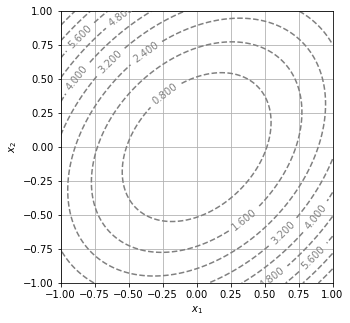

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

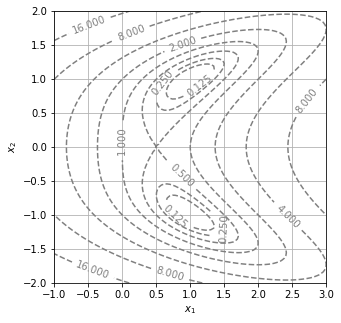

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

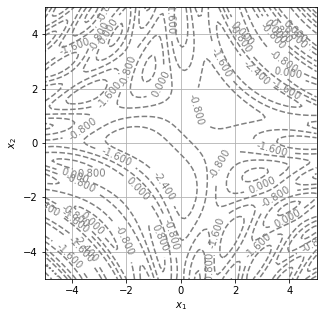

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = 1e-3#la méthode de newton ne nécessite pas une très grande précision, le résultat reste globalement incgangé
#pour des valeurs de eps plus faible

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    x0, y0 = x0, y0
    J_F = J(F)
    for i in range(N):
        A = J_F(x0, y0)
        B = -F(x0,y0)
        x_int, y_int = np.linalg.solve(A, B) #on résout cette équation plutôt que de calculer l'inverse pour réduire la complexité
        x, y = x_int + x0, y_int + y0
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

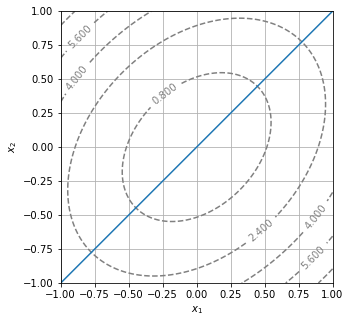

((0.4472135970019964, 0.4472135970019964),
 (-0.4472135970019964, -0.4472135970019964))

In [15]:
def F(x, y):
    return np.array([f1(x, y)- 0.8, x - y])

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=[0.8*i for i in range(1,10,2)], # 5 levels, automatically selected
)

x = np.linspace(-1.0, 1.0 ,100)
plt.plot(x,x)
plt.show();

Newton(F, 0.8, 0.8), Newton(F, -0.8, -0.8)


### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [17]:
def genepoint_droite(f, x0, y0, delta):
    #génère un point à "droite" du gradient de f en (x0, y0)
    grad_f = grad(f)(x0, y0).reshape(2, 1)
    R = np.array([0, 1, -1, 0]).reshape(2, 2)#matrice de rotation de -pi/2
    grad_a_droite = np.dot(R, grad_f)
    grad_a_droite = (delta/np.linalg.norm(grad_a_droite))*grad_a_droite
    x, y = float(x0 + grad_a_droite[0]), float(y0 + grad_a_droite[1])
    return x, y

def level_curve(f, x0, y0, delta = 0.1, N=1000, eps = eps ) :
    c = f(x0, y0)
    res = np.empty(shape = (2,N))#liste des résultats successifs
    res[:, 0] = x0, y0
    for i in range (N-1) :
        
        def F(x, y):#on "complète" f en une fonction dans R2 de manière à avoir la condition sur delta
            return np.array([f(x, y) - c, np.sqrt((x0 - x)**2 + (y - y0)**2) - delta])
        x, y = genepoint_droite(f, x0, y0, delta)
        x0, y0 = Newton(F, x, y)
        res[:, i + 1] = x0, y0
        
    return res

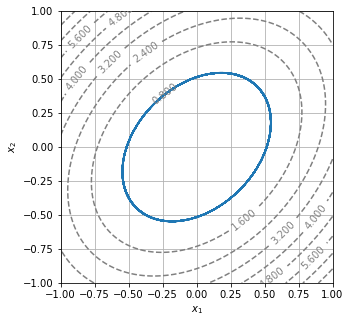

In [23]:
#test de la fonction level_curve avec f1
def solution_f1(c):#retourne une solution avec la méthode de newton de f1(x, y) = c et x - y =0
    x0, y0 = 2.0, 5.0 #point de départ arbitraire
    def F1(x, y):
        return np.array([f1(x, y) - c, x - y])
    x, y = Newton(F1, x0, y0)
    return x, y
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
x0, y0 = solution_f1(0.8)
points = level_curve(f1, x0, y0)
plt.plot(points[0,:], points[1,:]);
#Le résulat semble satisfaisant

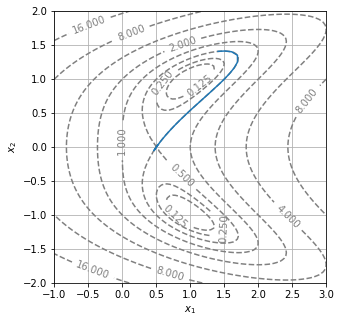

In [21]:
#test avec la fonction f2 et la boucle en  0.5
def solution_f2(c):#retourne une solution avec la méthode de newton de f2(x, y) = c et x - y =0
    x0, y0 = 2.0, 5.0 #point de départ arbitraire
    def F2(x, y):
        return np.array([f2(x, y) - c, x - y])
    x, y = Newton(F2, x0, y0)
    return x, y
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
x0, y0 = solution_f2(0.5)
points = level_curve(f2, x0, y0)
plt.plot(points[0,:], points[1,:]);
#Problème, on ne parcourt qu'une partie de la ligne de niveau 0.5 ... on s'arrête au croisement


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [24]:
def genepoint_gauche(f, x0, y0, delta):
    #génère un point à "gauche" du gradient de f en (x0, y0)
    grad_f = grad(f)(x0, y0).reshape(2, 1)
    R = np.array([0, 1, -1, 0]).reshape(2, 2) #matrice de rotation de -pi/2
    grad_a_droite = np.dot(R, grad_f)
    grad_a_droite = (delta/np.linalg.norm(grad_a_droite))*grad_a_droite
    x, y = float(x0 - grad_a_droite[0]), float(y0 - grad_a_droite[1])
    return x, y

def level_curve_upgraded(f, x0, y0, delta = 0.1, N=1000, eps = eps ) :
    x_init, y_init = x0, y0 #on veut 'sauvergarder' ces données pour empêcher un éventuel bouclage
    c = f(x0, y0)
    res = np.empty(shape = (2,N))#liste des résultats successifs
    res[:, 0] = x0, y0
    for i in range (N-1) :
        
        def F(x, y): #on "complète" f en une fonction dans R2 de manière à avoir la condition sur delta
            return np.array([f(x, y) - c, np.sqrt((x0 - x)**2 + (y - y0)**2) - delta])
        
        x, y = genepoint_droite(f, x0, y0, delta)
        
        if i>=1 and np.sqrt((x - res[0, i - 1])**2 + (y - res[1, i - 1])**2) < np.sqrt(2) * delta :
            x, y = genepoint_gauche(f, x0, y0, delta)
            
        x0, y0 = Newton(F, x, y)
        res[:, i + 1] = x0, y0
        
        if np.sqrt((x_init - res[0, -1])**2 + (y_init - res[1, -1])**2) < delta : #on vérifie que le dernier point construit est loin du point initial 
            return res
        
    return res

In [60]:
#La condition :
#if i>=1 and np.sqrt((x - res[0, i - 1])**2 + (y - res[1, i - 1])**2) < np.sqrt(2) * delta :
            #x, y = genepoint_gauche(f, x0, y0, delta)
#introduite en correction traduit le fait que oui ou non le terme construit par gene_point_droite(f, x0, y0, delta)
#est suffisamment éloigné du terme i - 1 de la ligne de niveau, s'il ne l'est pas on ne cherche pas un point à 
#droite mais à gauche du gradient de f en (x0, y0)

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

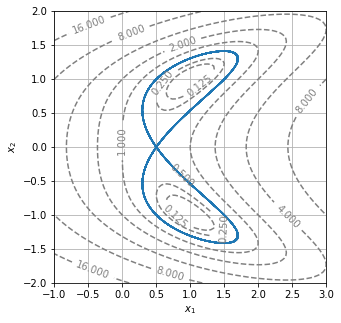

In [26]:
#test avec la fonction f2 et la boucle en  0.5
def solution_f2(c):#retourne une solution avec la méthode de newton de f2(x, y) = c et x - y =0
    x0, y0 = 2.0, 5.0 #point de départ arbitraire
    def F2(x, y):
        return np.array([f2(x, y) - c, x - y])
    x, y = Newton(F2, x0, y0)
    return x, y
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
x0, y0 = solution_f2(0.5)
points = level_curve_upgraded(f2, x0, y0)
plt.plot(points[0,:], points[1,:]);

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

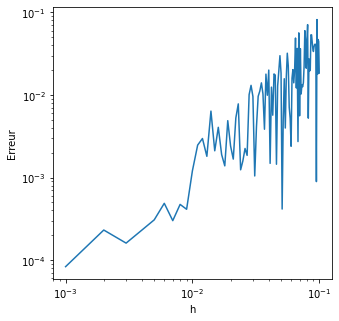

In [63]:
def entourer(f, c, h):
    #on crée un carré centré en (0, 0)
    n, nbis = 1, 0
    est_dedans = False
    au_moins_un_carre = False #il est nécessaire de vérifier si l'aire est dans le carré sinon la boucle s'arrête directement
    while not(est_dedans):
        if nbis == n:
            est_dedans = True
        
        #on regarde si le carré entoure l'aire
        
        else:
            #on regarde d'abord les coins du carré suivant
            if f(-(n + 1/2)*h, (n + 1/2)*h) <= c or f(-(n + 1/2)*h, -(n + 1/2)*h) <= c or f((n + 1/2)*h, (n + 1/2)*h) <= c or f((n + 1/2)*h, -(n + 1/2)*h) <= c:
                n += 1
                au_moins_un_carre = True
            
            #on regarde les carrés longeant la bordure du carre actuel
            else :
                for i in range(0, 2*n):
                    if f((i + 1/2 - n)*h, n*h + h/2) <= c or f((i + 1/2 - n)*h, -n*h - h/2) <= c or f(-n*h - h/2, (i + 1/2 - n)*h) <= c or f(n*h + h/2, (i + 1/2 - n)*h) <= c :
                        n += 1
                        au_moins_un_carre = True
                        break
                    
        nbis += 1
        if not(au_moins_un_carre) : 
            n += 1
    return n
    
def  area_squares(f, c, h):
    #on commence par encadrer l'aire
    n = entourer(f, c, h)
    
    #on parcourt ensuite la discrétisation de ce carré en petits carrés de côté h
    nb_carres = 0
    for j in range(0, 2*n):
        for i in range(0, 2*n):
            if f((i + 1/2 - n)*h, (j + 1/2 - n)*h) <= c:
                nb_carres += 1
    return nb_carres * h**2

def cercle(x, y):
    return x**2 + y**2


X, Y = [], []
for i in np.linspace(1e-1, 1e-3, 100):
    X.append(i)
    y = area_squares(cercle, 1, i)
    Y.append(abs(y-np.pi))

plt.plot(X,Y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("h")
plt.ylabel("Erreur")
plt.show()

#on voit bien que l'erreur tend vers 0 lorsque h tend vers 0

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [64]:
def  area_squares_approx(f, c, h):
    """renvoit borne inférieur, borne supérieur"""
    #on commence par encadrer l'aire
    n = entourer(f, c, h)
    
    #on parcourt ensuite la discrétisation de ce carré en petit carré de côté h
    nb_carres = 0
    nb_carres_entierement_dedans = 0
    for j in range(0, 2*n):
        for i in range(0, 2*n):
            if f((i + 1/2 - n)*h, (j + 1/2 - n)*h) <= c:
                nb_carres += 1
            #on vérifie si le carré est entièrement dedans en regardant si tous ses coins sont dedans
            if f((i - n)*h, (j - n)*h) <= c and f((i + 1 - n)*h, (j - n)*h) <= c and f((i + 1 - n)*h, (j + 1 - n)*h) <= c and f((i - n)*h, (j + 1 - n)*h) <= c : 
                nb_carres_entierement_dedans += 1
    return nb_carres_entierement_dedans * h**2, nb_carres * h**2

bas, haut = area_squares_approx(cercle, 1, 10**-2)
print(f"L'aire est comprise entre {bas} et {haut} avec une précision de 10**-2")
#on obtient bien une approximation à 10**-2 près

L'aire est comprise entre 3.1016000000000004 et 3.1428000000000003 avec une précision de 10**-2


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

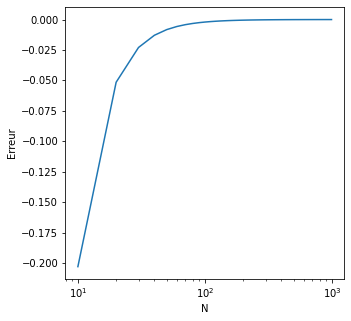

In [65]:
def aire_triangle(a, b, c):
        """a, b, c sont les longueurs des côtés du triangle"""
        demi_p = (a + b + c)/2
        return float(np.sqrt(demi_p * (demi_p - a)*(demi_p - b)*(demi_p - c)))

def methode_triangle(frontiere, p):
    res = 0
    N = len(frontiere)
    for i in range(N-1):
        a = np.linalg.norm(frontiere[i] - frontiere[i+1])
        b = np.linalg.norm(p - frontiere[i+1])
        c = np.linalg.norm(p - frontiere[i])
        
        if np.linalg.det(np.array([frontiere[i+1] - p, frontiere[i] - p])) >= 0:
            res += aire_triangle(a, b, c)
        else:
            res -= aire_triangle(a, b, c)
        
    return abs(res)

X = []
Y = []
for N in range(10, 1000, 10):
    X.append(N)
    Bn = np.array([[np.cos(-2*np.pi/N*i), np.sin(-2*np.pi/N*i)] for i in range(N+1)])
    Y.append(methode_triangle(Bn, np.array([0,0])) - np.pi)

plt.plot(X, Y)
plt.xlabel("N")
plt.ylabel("Erreur")
plt.xscale("log")
plt.show()
#l'erreur tend bien vers 0

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [66]:
#utiliser des aires potentiellement négatives permet de retiré l'aire ajouté par le fait que le point se situe à
#l'extérieur de l'aire à calculer

N = 500
Bn = np.array([[np.cos(2*np.pi/N*i), np.sin(2*np.pi/N*i)] for i in range(N+1)])

print(f"L'aire est {methode_triangle(Bn, [-6,2])}")
#on retrouve bien l'aire d'un cercle

L'aire est 3.141509970838046


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

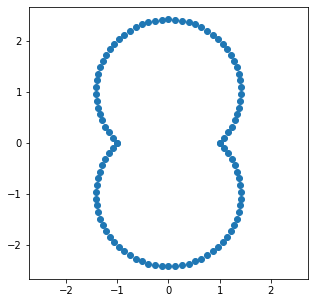

L'aire est 11.410831331851483


In [67]:
#on considère deux cercles ayant leur centre sur l'abscisse dechaque côté de (0, 0) à une distance dist
N = 100
dist = 1
theta = np.pi/4
R = dist / np.cos(theta)
Bn1 = np.array([[R * np.cos(-theta + 4*(np.pi-theta)/N * i), R * np.sin(-theta + 4*(np.pi - theta)/N * i) + dist] for i in range(int(N/2) + 1)])
Bn2 = np.array([[R * np.cos(np.pi - theta + 4*(np.pi-theta)/N * i), R * np.sin(np.pi - theta + 4*(np.pi - theta)/N * i) - dist] for i in range(int(N/2) + 1)])

Bn = np.concatenate((Bn1,Bn2))

plt.scatter(Bn[:,0], Bn[:, 1])
plt.axis("equal")
plt.show();

aire = methode_triangle(Bn, [-7,3])
print(f"L'aire est {aire}")


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [68]:
def area_triangle(x,y):
    p = [0, 0]
    frontiere = np.array([[x[i], y[i]] for i in range(len(x))])
    return methode_triangle(frontiere, p)

#f permet de définir l'ensemble de sous-niveau considéré précédemment
def f(x, y):
    if y <=0:
        return np.sqrt(x**2 + (y + dist)**2)
    else :
        return np.sqrt(x**2 + (y - dist)**2)

carre = area_squares(f, R, 1e-2)
triangle = area_triangle(Bn[:,0], Bn[:, 1])

print(f"L'aire donnée par la méthode est rectangle est {carre}")
print(f"L'aire donnée par la méthode est triangle est {triangle}")
#sur l'ensemble de sous-niveau considéré précédemment, les deux méthodes donnent des résultats cohérents entre elles

#la méthode des carrés présente l'avantage de ne pas nécessiter une discrétisation de la ligne de niveau considéré
#et est donc plus général que la méthode des triangles de ce point de vue la. Cependant, la méthode des carrés a le
#gros désavantage de devoir chercher où se trouve l'aire à calculer. En effet, on démarre la fonction entourer
#autour du point (0, 0) et donc plus h sera petit et plus l'aire à calculer sera excentrée, plus l'algorithme sera
#long à exécuter.

L'aire donnée par la méthode est rectangle est 11.4176
L'aire donnée par la méthode est triangle est 11.41083133185143
